<h1 align = "center" style="font-size:60px;">
Fake News Detection
</h1>

<center><img src="img.jpg" alt="FakeNewsImage"></center>



## Importing libraries

In [39]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
tick = perf_counter()

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Data loading, pre-processing and EDA

In [40]:
#loading data
path_train = r'train\train.csv'
df = pd.read_csv(path_train)

In [41]:
#checking data
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [42]:
#checking a typical title
df.title[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [43]:
#checking a typical text
df.text[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [44]:
#checking shape of data
df.shape

(20800, 5)

In [45]:
#checking missing values
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [46]:
#filling missing values with empty string
df = df.fillna("")

In [47]:
#again looking if there are any missing values that remain
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [48]:
#merging author name and news title
df["content"] = df['author'] + ' ' + df['title']

In [49]:
#checking count of lables
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [50]:
#importing porter stemmer
port_stem = PorterStemmer()

In [51]:
#processing "content" column of data
def stemming(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

In [52]:
#calling stemming function on "content" column
df['content'] = df['content'].apply(stemming)

## Preparing data for Model building

In [53]:
#separating data and label
X = df['content']
y = df["label"]

In [54]:
#checkig shape of X
X.shape

(20800,)

In [55]:
#checking shape of y
y.shape

(20800,)

In [56]:
#splitting data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=2)

In [57]:
#chekcing shape of train data
X_train.shape

(16640,)

In [58]:
#chekcing shape of test data
X_test.shape

(4160,)

In [59]:
# converting the textual data to numerical data using tf-idf model
vectorizer = TfidfVectorizer(max_features = 5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [60]:
#looking at  features names in tf-idf model
vectorizer.get_feature_names_out()

array(['aaron', 'ab', 'abandon', ..., 'zu', 'zuckerberg', 'zuess'],
      dtype=object)

In [61]:
#making df of vectorized train data
train_df = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
train_df.shape

(16640, 5000)

In [62]:
#making df of vectorized train data
test_df = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())
test_df.shape

(4160, 5000)

## Model Building and Analysis

In [63]:
#importing multiple models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

#function to build models one by one and store their results simultaneously
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    """
    Lightweight script to test many models and find winners.
        Parameters:
            X_train: training split
            y_train: training target vector
            X_test: test split
            y_test: test target vector
        Return:
            DataFrame of predictions
    """
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('MNB', MultinomialNB()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    # scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    # target_names = ['unreliable', 'reliable']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring="accuracy", 
                                                    return_train_score = False, return_estimator = False)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [64]:
#dataframe with all the results of all models
final_df = run_exps(X_train, y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2077
           1       0.97      0.99      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160

RF
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2077
           1       0.99      1.00      0.99      2083

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160

KNN
              precision    recall  f1-score   support

           0       1.00      0.10      0.18      2077
           1       0.53      1.00      0.69      2083

    accuracy                           0.55      4160
   macro avg       0.76      0.55      0.43      4160
weighted avg       0.76      0.55      0.43      4160

SVM
 

## Analysing Models

In [65]:
#checking shape
final_df.shape

(30, 4)

In [66]:
#using sampling in the results of model metrics to allow for comparison based on boxplots later on
bootstraps = []
for model in list(set(final_df.model.values)):
    model_df = final_df.loc[final_df.model == model]
    # print(model_df)
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

In [67]:
#concatening samples results for different models
bootstrap_df = pd.concat(bootstraps, ignore_index=True)

In [68]:
#checking for sampled df
bootstrap_df

,fit_time,score_time,test_score,model
0,30.627971,2.487172,0.990084,SVM
1,30.627971,2.487172,0.990084,SVM
2,34.594054,2.659682,0.984675,SVM
3,35.928166,2.448558,0.988281,SVM
4,35.928166,2.448558,0.988281,SVM
...,...,...,...,...
175,0.000000,0.000000,0.952524,MNB
176,0.007133,0.000000,0.937500,MNB
177,0.000000,0.000000,0.954026,MNB
178,0.000000,0.000000,0.952524,MNB


In [69]:
#sorting models based on accuracy
bootstrap_df.groupby(by = "model")["test_score"].median().round(3).sort_values()

model
KNN       0.542
MNB       0.953
LogReg    0.976
SVM       0.988
XGB       0.988
RF        0.992
Name: test_score, dtype: float64

In [70]:
#storing sorted models based on accuracy scores
index_score = bootstrap_df.groupby(by = "model")["test_score"].median().round(3).sort_values().index

In [71]:
#checking sorted models
index_score

Index(['KNN', 'MNB', 'LogReg', 'SVM', 'XGB', 'RF'], dtype='object', name='model')

In [72]:
#sorting models based on fitting time
bootstrap_df.groupby(by = "model")["fit_time"].median().round(3).sort_values()

model
KNN        0.001
MNB        0.007
LogReg     0.102
XGB        1.205
RF         9.778
SVM       34.594
Name: fit_time, dtype: float64

In [73]:
#storing sorted models based on fit time
index_time = bootstrap_df.groupby(by = "model")["fit_time"].median().round(3).sort_values().index

In [74]:
#checking sorted models
index_time

Index(['KNN', 'MNB', 'LogReg', 'XGB', 'RF', 'SVM'], dtype='object', name='model')

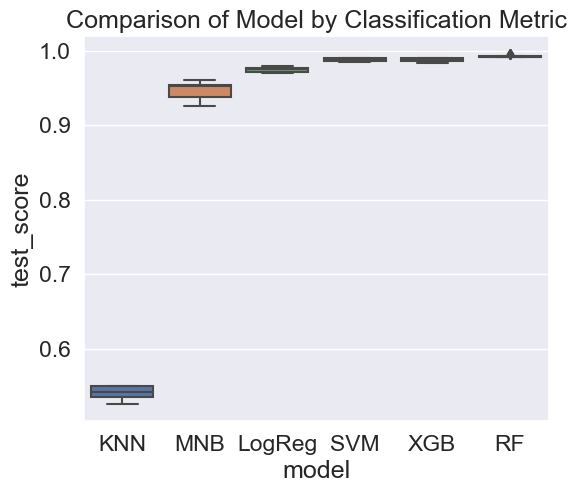

In [75]:
#boxplot of models based on accuracy scores
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.5)
sns.boxplot(bootstrap_df, x = "model", y = "test_score", order = index_score)
# plt.legend(["Accuracy"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric');

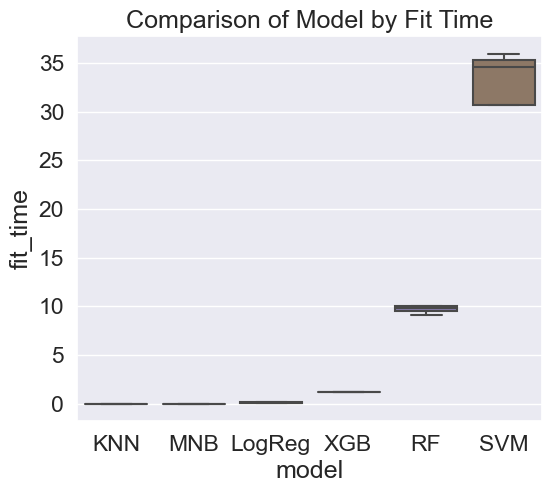

In [76]:
#boxplot of models based on fit times
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.5)
sns.boxplot(bootstrap_df, x = "model", y = "fit_time", order = index_time)
# plt.legend(["Accuracy"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit Time');

## Trying a different way to plot models based on accuracy and fit times

In [77]:
#converting bootstrapped df into long format
results_long = pd.melt(bootstrap_df, id_vars=['model'], var_name='metrics', value_name='values')

In [78]:
#checking long format df
results_long

,model,metrics,values
0,SVM,fit_time,30.627971
1,SVM,fit_time,30.627971
2,SVM,fit_time,34.594054
3,SVM,fit_time,35.928166
4,SVM,fit_time,35.928166
...,...,...,...
535,MNB,test_score,0.952524
536,MNB,test_score,0.937500
537,MNB,test_score,0.954026
538,MNB,test_score,0.952524


In [79]:
#sorting models based on accuracy
results_long[results_long["metrics"] == "test_score"].groupby(by = ["model", "metrics"]).median().round(3).sort_values(by = "values").index

MultiIndex([(   'KNN', 'test_score'),
            (   'MNB', 'test_score'),
            ('LogReg', 'test_score'),
            (   'SVM', 'test_score'),
            (   'XGB', 'test_score'),
            (    'RF', 'test_score')],
           names=['model', 'metrics'])

In [80]:
#storing sorted models 
index_score = results_long[results_long["metrics"] == "test_score"].groupby(by = ["model", "metrics"]).median().round(3).sort_values(by = "values").index

In [81]:
#checking sorted models
index_score

MultiIndex([(   'KNN', 'test_score'),
            (   'MNB', 'test_score'),
            ('LogReg', 'test_score'),
            (   'SVM', 'test_score'),
            (   'XGB', 'test_score'),
            (    'RF', 'test_score')],
           names=['model', 'metrics'])

In [82]:
#dropping level from multiindex
index_score.droplevel(1)

Index(['KNN', 'MNB', 'LogReg', 'SVM', 'XGB', 'RF'], dtype='object', name='model')

In [83]:
#sorting models based on fit times
results_long[results_long["metrics"] == "fit_time"].groupby(by = ["model", "metrics"]).median().round(3).sort_values(by = "values").index

MultiIndex([(   'KNN', 'fit_time'),
            (   'MNB', 'fit_time'),
            ('LogReg', 'fit_time'),
            (   'XGB', 'fit_time'),
            (    'RF', 'fit_time'),
            (   'SVM', 'fit_time')],
           names=['model', 'metrics'])

In [84]:
#storing sorted models 
index_time = results_long[results_long["metrics"] == "fit_time"].groupby(by = ["model", "metrics"]).median().round(3).sort_values(by = "values").index

In [85]:
#checking sorted models
index_time

MultiIndex([(   'KNN', 'fit_time'),
            (   'MNB', 'fit_time'),
            ('LogReg', 'fit_time'),
            (   'XGB', 'fit_time'),
            (    'RF', 'fit_time'),
            (   'SVM', 'fit_time')],
           names=['model', 'metrics'])

In [86]:
#dropping level from multiindex
index_time.droplevel(1)

Index(['KNN', 'MNB', 'LogReg', 'XGB', 'RF', 'SVM'], dtype='object', name='model')

In [87]:
#PERFORMANCE METRICS
results_long_nofit = results_long.loc[results_long['metrics']=="test_score"] # get df without fit data

In [88]:
#checking shape of accuracy data
results_long_nofit.shape

(180, 3)

In [89]:
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'] == "fit_time"] # df with fit data

In [90]:
#checking shape of fit time data
results_long_fit.shape

(180, 3)

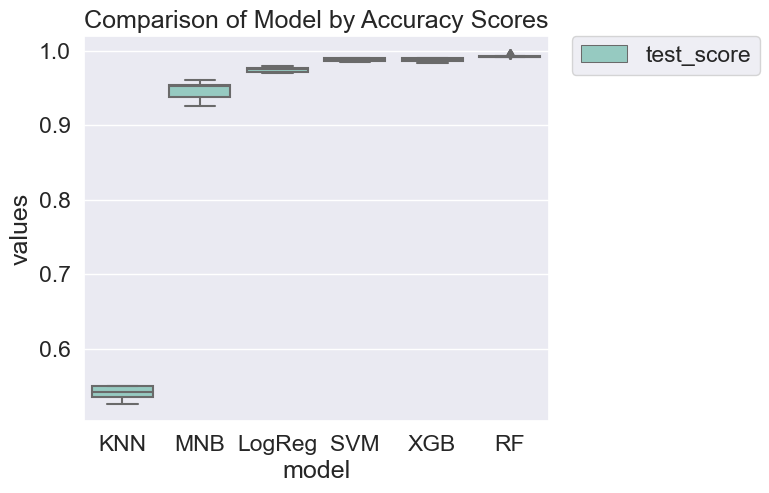

In [91]:
#plotting boxplots of models based on accuracy scores
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3", order = index_score.droplevel(1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Accuracy Scores');

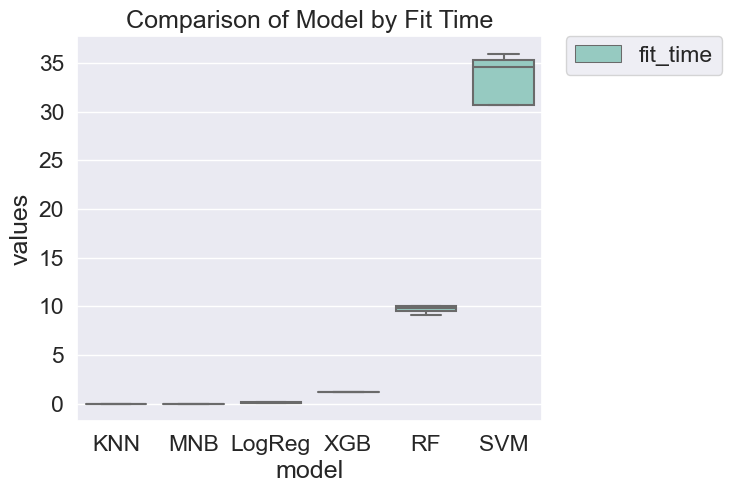

In [92]:
plt.figure(figsize=(6,5))
sns.set(font_scale=1.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3", order = index_time.droplevel(1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit Time');

In [93]:
tock = perf_counter()

In [94]:
print(f'Time taken to run this notebook: {round((tock-tick)/60, 2)} mins')

Time taken to run this notebook: 7.22 mins
